In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
import string
import warnings
from wordcloud import WordCloud, STOPWORDS
import pickle

# plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from gensim.models.doc2vec import LabeledSentence
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc

In [3]:
# load pickle
df = pd.read_pickle('final-data2.pickle')
df.head()

text  \
0                                                                Just happened a terrible car crash   
1                             Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
2                                  Heard about #earthquake is different cities, stay safe everyone.   
3  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all   
4                                                            Forest fire near La Ronge Sask. Canada   

   choose_one  \
0           1   
1           1   
2           1   
3           1   
4           1   

                                                                                         tidy_tweet  \
0                                                                just happened a terrible car crash   
1                             our deeds are the reason of this  earthquake may allah forgive us all   
2                                  heard about  earthquake is different cities  stay safe everyone    
3  there is a forest fire at spot pond  geese are fleeing across the street  i cannot save them all   
4                                                            forest fire near la ronge sask  canada   

   polarity  review_len  word_count  \
0     -1.00          34           6   
1      0.00          69          13   
2      0.25          64           9   
3      0.00          96          19   
4      0.10          38           7   

                                                                                         contracted  \
0                                                                Just happened a terrible car crash   
1                             Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
2                                  Heard about #earthquake is different cities, stay safe everyone.   
3  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all   
4                                                            Forest fire near La Ronge Sask. Canada   

                                                                                                               tokens  \
0                                                                           [Just, happened, a, terrible, car, crash]   
1                                  [Our, Deeds, are, the, Reason, of, this, earthquake, May, ALLAH, Forgive, us, all]   
2                                           [Heard, about, earthquake, is, different, cities, stay, safe, everyone, ]   
3  [there, is, a, forest, fire, at, spot, pond, geese, are, fleeing, across, the, street, I, cannot, save, them, all]   
4                                                                       [Forest, fire, near, La, Ronge, Sask, Canada]   

                                                               normalize  \
0                                         [happen, terrible, car, crash]   
1                     [deed, reason, earthquake, may, allah, forgive, u]   
2             [heard, earthquake, different, city, stay, safe, everyone]   
3  [forest, fire, spot, pond, geese, flee, across, street, cannot, save]   
4                          [forest, fire, near, la, ronge, sask, canada]   

                                           normalize_stitched  
0                                   happen terrible car crash  
1                  deed reason earthquake may allah forgive u  
2          heard earthquake different city stay safe everyone  
3  forest fire spot pond geese flee across street cannot save  
4                       forest fire near la ronge sask canada

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
train.shape, test.shape

((8688, 10), (2172, 10))

In [34]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [37]:
combi = train.append(test, ignore_index=True)

In [39]:
train.shape, test.shape

((8688, 10), (2172, 10))

## Bag of Words

In [40]:
def BoW(df):
    bow_vectorizer = CountVectorizer(max_df=0.9, min_df=2, max_features=1000)
    bow = bow_vectorizer.fit_transform(df['normalize_stitched'])
    return bow

In [41]:
bow = BoW(combi)

In [42]:
bow.shape

(10860, 1000)

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['normalize_stitched'])

bow.shape

## TF-IDF

In [43]:
def tfidf(df):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(df['normalize_stitched'])
    return tfidf

In [44]:
tfidf = tfidf(combi)

In [45]:
tfidf.shape

(10860, 1000)

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['normalize_stitched'])

tfidf.shape

## Word2Vec

In [46]:
def w2v(df):
    model_w2v = gensim.models.Word2Vec(df['normalize'], 
                                   size=200, # desired number of features
                                   window=5, # context window size
                                   min_count=2,
                                   sg=1, # 1 for skip-gram model
                                   hs=0,
                                   negative=10, # for negative sampling
                                   workers=2, # no. of cores
                                   seed=34
                                  )
    return model_w2v

In [47]:
model_w2v = w2v(combi)

In [48]:
model_w2v.wv.most_similar(positive='attack')

[('militant', 0.92835533618927),
 ('muslim', 0.9258299469947815),
 ('christian', 0.925666332244873),
 ('udhampur', 0.9219797253608704),
 ('post', 0.9183995723724365),
 ('police', 0.90301913022995),
 ('spos', 0.9026702642440796),
 ('terror', 0.8901731967926025),
 ('temple', 0.8858988881111145),
 ('terrorist', 0.8857553601264954)]

model_w2v = gensim.models.Word2Vec(df['normalize'], 
                                   size=200, # desired number of features
                                   window=5, # context window size
                                   min_count=2,
                                   sg=1, # 1 for skip-gram model
                                   hs=0,
                                   negative=10, # for negative sampling
                                   workers=2, # no. of cores
                                   seed=34
                                  )

model_w2v.wv.most_similar(positive='attack')

In [49]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1
        except KeyError:
            continue
    
    if count != 0:
        vec /= count
    
    return vec

In [50]:
# Prepaing Word2Vec feature set
wordvec_arrays = np.zeros((len(combi['normalize']), 200))
for i in range(len(combi['normalize'])):
    wordvec_arrays[i,:] = word_vector(combi['normalize'][i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)

In [51]:
wordvec_df.shape

(10860, 200)

In [52]:
# model function
def model(corpus, model, w2v=False):
    if w2v is True:
        train_corpus = corpus.iloc[:8688, :]
        test_corpus = corpus.iloc[8688:, :]
    else:
        train_corpus = corpus[:8688, :]
        test_corpus = corpus[8688:, :]
    
    xtrain_corpus, xvalid_corpus, ytrain, yvalid = train_test_split(train_corpus, xtrain['choose_one'], random_state=42)
    
    model.fit(xtrain_corpus, ytrain)
    prediction = model.predict(xvalid_corpus)
    probs = model.predict_proba(xvalid_corpus)
    preds = probs[:, 1]
    #prediction_int = prediction[:, 1] >= 0.3
    #prediction_int = prediction_int.astype(np.int)
    #accuracy = accuracy_score(yvalid, prediction)
    precision = precision_score(yvalid, prediction)
    recall = recall_score(yvalid, prediction)
    accuracy = accuracy_score(yvalid, prediction)
    fpr, tpr, threshold = roc_curve(yvalid, ypred)
    
    return accuracy, precision, recall

### Logistic Regression

In [74]:
# BoW
train_bow = bow[:8688, :]
test_bow = bow[8688:, :]

In [75]:
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['choose_one'], test_size=0.2, random_state=42)

In [76]:
lreg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=42)
lreg.fit(xtrain_bow, ytrain)

y_pred = lreg.predict(xvalid_bow)
y_prob = lreg.predict_proba(xvalid_bow)

In [77]:
def get_metrics(y_true, y_pred, y_prob=None):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_true, y_pred, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_true, y_pred, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_true, y_pred, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_true, y_pred)
    
    fpr, tpr, threshold = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, roc_auc, fpr, tpr

In [78]:
def plot_roc_auc(fpr, tpr, auc):
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [79]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.778, precision = 0.778, recall = 0.778, f1 = 0.778, auc = 0.844


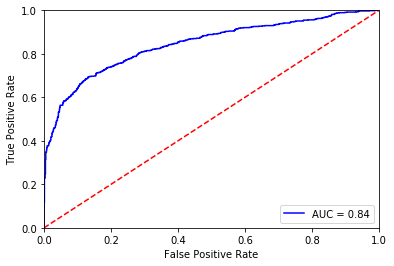

In [80]:
plot_roc_auc(fpr, tpr, roc_auc)

In [81]:
# tfidf
train_tfidf = tfidf[:8688, :]
test_tfidf = tfidf[8688:, :]

In [82]:
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [83]:
lreg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=42)
lreg.fit(xtrain_tfidf, ytrain)

y_pred = lreg.predict(xvalid_tfidf)
y_prob = lreg.predict_proba(xvalid_tfidf)

In [84]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.781, precision = 0.781, recall = 0.781, f1 = 0.781, auc = 0.847


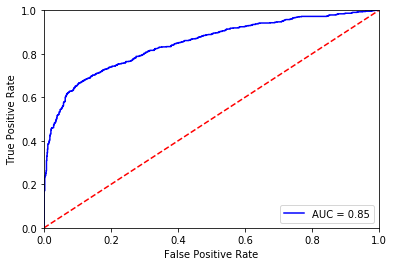

In [85]:
plot_roc_auc(fpr, tpr, roc_auc)

In [86]:
# Word2Vec
train_w2v = wordvec_df.iloc[:8688, :]
test_w2v = wordvec_df.iloc[8688:, :]

In [88]:
xtrain_w2v = train_w2v.iloc[ytrain.index]
xvalid_w2v = train_w2v.iloc[yvalid.index]

In [89]:
lreg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=42)
lreg.fit(xtrain_w2v, ytrain)

y_pred = lreg.predict(xvalid_w2v)
y_prob = lreg.predict_proba(xvalid_w2v)

In [90]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.749, precision = 0.750, recall = 0.749, f1 = 0.749, auc = 0.824


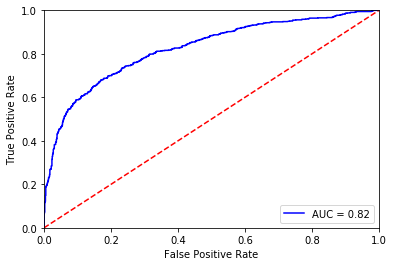

In [91]:
plot_roc_auc(fpr, tpr, roc_auc)

## Support Vector Machines

In [92]:
# BoW
svc = SVC(kernel='linear', C=1, probability=True)
svc.fit(xtrain_bow, ytrain)

y_pred = svc.predict(xvalid_bow)
y_prob = svc.predict_proba(xvalid_bow)

In [93]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.789, precision = 0.792, recall = 0.789, f1 = 0.786, auc = 0.847


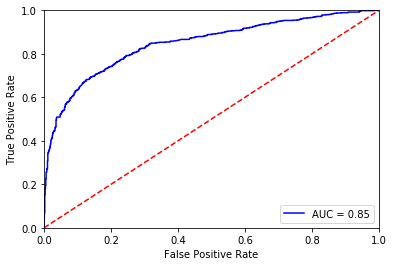

In [94]:
plot_roc_auc(fpr, tpr, roc_auc)

In [95]:
# Tf-idf
svc = SVC(kernel='linear', C=1, probability=True)
svc.fit(xtrain_tfidf, ytrain)

y_pred = svc.predict(xvalid_tfidf)
y_prob = svc.predict_proba(xvalid_tfidf)

In [96]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.789, precision = 0.792, recall = 0.789, f1 = 0.785, auc = 0.849


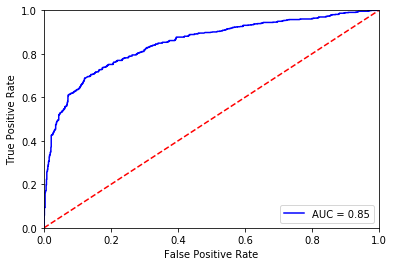

In [97]:
plot_roc_auc(fpr, tpr, roc_auc)

In [98]:
# Word2Vec
svc = SVC(kernel='linear', C=1, probability=True)
svc.fit(xtrain_w2v, ytrain)

y_pred = svc.predict(xvalid_w2v)
y_prob = svc.predict_proba(xvalid_w2v)

In [99]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.742, precision = 0.753, recall = 0.742, f1 = 0.731, auc = 0.807


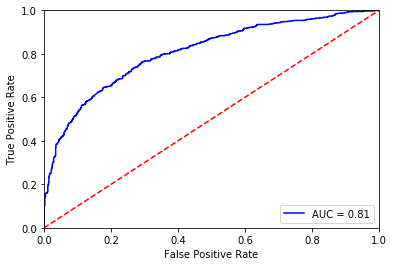

In [100]:
plot_roc_auc(fpr, tpr, roc_auc)

## Random Forest

In [101]:
# BoW
forest = RandomForestClassifier(n_estimators=400, random_state=42)
forest.fit(xtrain_bow, ytrain)

y_pred = forest.predict(xvalid_bow)
y_prob = forest.predict_proba(xvalid_bow)

In [102]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.792, precision = 0.793, recall = 0.792, f1 = 0.789, auc = 0.841


In [103]:
# Tf-Idf
forest = RandomForestClassifier(n_estimators=400, random_state=42)
forest.fit(xtrain_tfidf, ytrain)

y_pred = forest.predict(xvalid_tfidf)
y_prob = forest.predict_proba(xvalid_tfidf)

In [104]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.783, precision = 0.786, recall = 0.783, f1 = 0.779, auc = 0.846


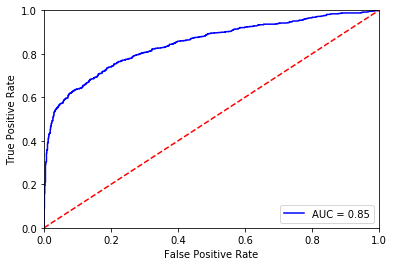

In [105]:
plot_roc_auc(fpr, tpr, roc_auc)

In [106]:
# Word2Vec
forest = RandomForestClassifier(n_estimators=400, random_state=42)
forest.fit(xtrain_w2v, ytrain)

y_pred = forest.predict(xvalid_w2v)
y_prob = forest.predict_proba(xvalid_w2v)

In [107]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.781, precision = 0.783, recall = 0.781, f1 = 0.778, auc = 0.833


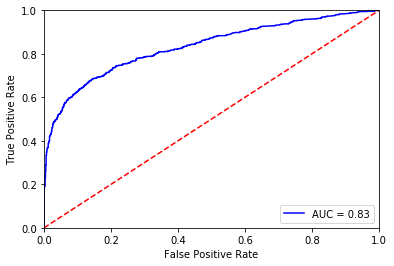

In [108]:
plot_roc_auc(fpr, tpr, roc_auc)

## XGBoost

In [109]:
# BoW
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
xgb_model.fit(xtrain_bow, ytrain)

y_pred = xgb_model.predict(xvalid_bow)
y_prob = xgb_model.predict_proba(xvalid_bow)

In [110]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.792, precision = 0.795, recall = 0.792, f1 = 0.788, auc = 0.862


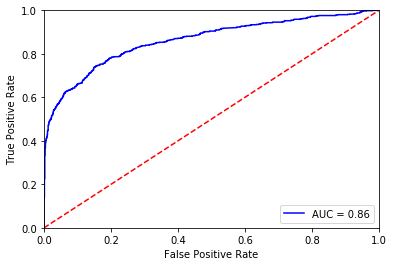

In [111]:
plot_roc_auc(fpr, tpr, roc_auc)

In [112]:
# Tf-Idf
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
xgb_model.fit(xtrain_tfidf, ytrain)

y_pred = xgb_model.predict(xvalid_tfidf)
y_prob = xgb_model.predict_proba(xvalid_tfidf)

In [113]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.789, precision = 0.791, recall = 0.789, f1 = 0.786, auc = 0.855


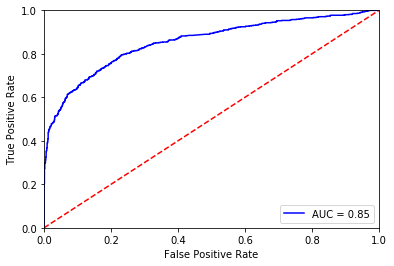

In [114]:
plot_roc_auc(fpr, tpr, roc_auc)

In [115]:
# Word2Vec
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
xgb_model.fit(xtrain_w2v, ytrain)

y_pred = xgb_model.predict(xvalid_w2v)
y_prob = xgb_model.predict_proba(xvalid_w2v)

In [116]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(yvalid, y_pred, y_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.777, precision = 0.778, recall = 0.777, f1 = 0.775, auc = 0.830


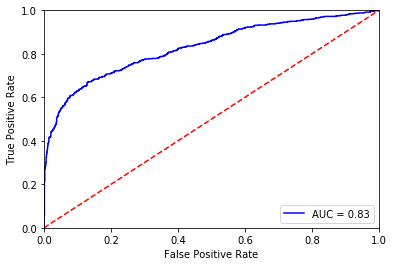

In [117]:
plot_roc_auc(fpr, tpr, roc_auc)

In [129]:
# best XGBoost + BoW
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
xgb_model.fit(xtrain_bow, ytrain)

test_pred = xgb_model.predict(test_bow)
test_prob = xgb_model.predict_proba(test_bow)
#test['label'] = test_pred

In [130]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(test['choose_one'], test_pred, test_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.789, precision = 0.790, recall = 0.789, f1 = 0.787, auc = 0.858


## Fine Tuning XGBoost + BoW

In [137]:
dtrain = xgb.DMatrix(xtrain_bow, label=ytrain)
dvalid = xgb.DMatrix(xvalid_bow, label=yvalid)
dtest = xgb.DMatrix(test_bow)

In [138]:
# parameters to tune
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1
}

In [139]:
# Tuning max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(5,8)
]

In [144]:
max_auc = 0 # Initializing with zero
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Cross-Validation
    cv_results = xgb.cv(params,
                        dtrain,
                        metrics={'auc'},
                        #feval=custom_eval,
                        num_boost_round=200,
                        maximize=True,
                        seed=16,
                        nfold=5,
                        early_stopping_rounds=10,
                        verbose_eval=False
                       )
    
    # Finding best F1 Score
    #mean_f1 = cv_results['test-f1_score-mean'].max()
    mean_auc = cv_results['test-auc-mean'].max()
    
    #boost_rounds = cv_results['test-f1_score-mean'].argmax()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    
    print("\tAUC Score {} for {} rounds".format(mean_auc, boost_rounds))

    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=6, min_child_weight=5
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

C:\Users\PARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



	AUC Score 0.8505545999999999 for 149 rounds
CV with max_depth=6, min_child_weight=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree

[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
	AUC Score 0.8483392000000001 for 86 rounds
CV with max_depth=7, min_child_weight=6
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[23:23:28] src/tree/

[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[23:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[23:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[23:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[23:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[23:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[23:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[23:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
	AUC Score 0.8515089999999998 for 82 rounds
CV with max_depth=9, min_child_weight=5
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/

[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[23:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[23:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[23:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[23:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[23:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

In [145]:
# Updating max_depth and min_child_weight params
params['max_depth'] = 8
params['min_child_weight'] = 6

In [147]:
# Tuning subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [149]:
max_auc = 0 # Initializing with zero
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(subsample, colsample))
    
    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample
    
    # Cross-Validation
    cv_results = xgb.cv(params,
                        dtrain,
                        metrics={'auc'},
                        #feval=custom_eval,
                        num_boost_round=200,
                        maximize=True,
                        seed=16,
                        nfold=5,
                        early_stopping_rounds=10,
                        verbose_eval=False
                       )
    
    # Finding best F1 Score
    #mean_f1 = cv_results['test-f1_score-mean'].max()
    mean_auc = cv_results['test-auc-mean'].max()
    
    #boost_rounds = cv_results['test-f1_score-mean'].argmax()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))

    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample, colsample)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=0.5, colsample=0.5
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8


C:\Users\PARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



	AUC 0.8507242000000002 for 63 rounds
CV with subsample=0.5, colsample=0.6
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_p

[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
	AUC 0.8507242000000002 for 63 rounds
CV with subsample=0.5, colsample=0.7
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:20] src/tree/updater_p

[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
	AUC 0.8516313999999999 for 73 rounds
CV with subsample=0.6, colsample=0.6
[00:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:31:48] src/tree/updater_p

[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
	AUC 0.8527072 for 94 rounds
CV with subsample=0.8, colsample=0.7
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:33:18] src/tree/updater_prune.cc:7

[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
	AUC 0.853898 for 96 rounds
CV with subsample=0.9, colsample=0.6
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:33:51] src/tree/updater_prune.cc:74

[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:33:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
	AUC 0.853898 for 96 rounds
CV with subsample=0.9, colsample=0.9
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:34:16] src/tree/updater_prune.cc:74

[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

In [150]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.5

In [152]:
# Tuning learning-rate
max_auc = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update ETA
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        metrics={'auc'},
        #feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20,
        verbose_eval=0
    )

    # Finding best F1 Score
    #mean_f1 = cv_results['test-f1_score-mean'].max()
    mean_auc = cv_results['test-auc-mean'].max()
    
    #boost_rounds = cv_results['test-f1_score-mean'].argmax()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta

print("Best params: {}, AUC: {}".format(best_params, max_auc))

CV with eta=0.3
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pr

[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

C:\Users\PARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



	AUC 0.8549268 for 150 rounds
CV with eta=0.2
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:37:52] src/tree/updater_prune.cc:74: tree pruning end,

[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_

[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_

[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_

[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_

[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_

[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[00:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_

[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_

[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[00:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

In [153]:
params['eta'] = 0.05

In [154]:
# Tuning gamma
max_auc = 0.
best_params = None
for gamma in range(0,15):
    print("CV with gamma={}".format(gamma/10.))

    # Update ETA
    params['gamma'] = gamma/10.

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        metrics={'auc'},
        #feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10,
        verbose_eval=100
    )

    # Finding best F1 Score
    #mean_f1 = cv_results['test-f1_score-mean'].max()
    mean_auc = cv_results['test-auc-mean'].max()
    
    #boost_rounds = cv_results['test-f1_score-mean'].argmax()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = gamma/10.

print("Best params: {}, AUC: {}".format(best_params, max_auc))

CV with gamma=0.0
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-auc:0.699454+0.00439025	test-auc:0.683133+0.0125124
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:43:47] src/tree/upda

[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[00:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[00:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[00:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[00:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

C:\Users\PARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



	AUC 0.8415724000000001 for 199 rounds
CV with gamma=0.1
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=8
[0]	train-auc:0.699439+0.0043921	test-auc:0.683138+0.0124727
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=8
[00:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 4 pruned nodes

[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 12 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 8 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=8
[00:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, 

[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=8
[00:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, ma

[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=8
[00:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, ma

[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 18 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, m

[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=8
[00:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 12 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, ma

[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=8
[00:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_

[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 14 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, m

[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, 

[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, ma

[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max

[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, max_depth=8
[00:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max

[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=8
[00:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max

[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max

[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=8
[00:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, ma

[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 8 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=8
[00:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes

[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 16 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=8
[00:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, 

[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 18 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 32 pruned nodes, max_depth=8
[00:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes

[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes,

[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 12 pruned nodes, max_depth=8
[00:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 14 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes

[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=8
[00:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, m

[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=8
[00:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes,

[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 30 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned node

[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, 

[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 16 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes

[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=8
[00:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max

[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, 

[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=8
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 16 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, m

[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 18 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=8
[00:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes,

[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=8
[00:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned node

[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 24 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=8
[00:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned node

[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 18 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes,

[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 24 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes,

[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes,

[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=8
[00:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, m

[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes

[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, 

[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 16 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes

[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 28 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 20 pruned nodes, max_depth=8
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes,

[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 14 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, m

[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, m

[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 14 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 12 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 6 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=8
[00:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes,

[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=8
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes

[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 22 pruned nodes, max_depth=8
[00:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nod

[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 32 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 26 pruned nodes

[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=8
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes,

[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 24 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 24 pruned no

[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 18 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes,

[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=8
[00:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, 

[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=8
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned node

[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes

[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes,

[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned node

[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes

[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned node

[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 8 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 22 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 20 pruned nodes, max_depth=8
[00:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 28 pruned nodes

[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 30 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 22 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 18 pruned nodes, max_depth=8
[00:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 20 pruned node

[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 28 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 16 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 18 pruned nodes, max_depth=8
[00:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 30 pruned no

[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=8
[00:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nod

[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 12 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes

[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nod

[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nod

[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned node

[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 20 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned node

[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned node

[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=8
[00:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned node

[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=8
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned node

[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes

[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes

[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 26 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 28 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 28 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 24 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned no

[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 10 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nod

[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 36 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 20 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nod

[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 40 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 18 pruned nodes, max_depth=8
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned no

[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=8
[00:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned node

[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 22 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned node

[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned node

[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes,

[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes,

[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned node

[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned node

[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes

[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes

[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes

[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 34 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 18 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 30 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=8
[00:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned no

[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 16 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 26 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 14 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned node

[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 30 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=8
[00:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nod

[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 18 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned node

[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned no

[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 12 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned node

[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nod

[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned node

[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned node

[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes,

[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes,

[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, 

[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 32 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 30 pruned nodes, max_depth=8
[00:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 30 pruned nod

[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 16 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 20 pruned no

[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned no

[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned node

[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 16 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nod

[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned node

[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 34 pruned nodes

[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, m

[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nod

[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes,

[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes

[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned node

[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes

[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[199]	train-auc:0.880657+0.00137844	test-auc:0.839954+0.00811973
	AUC 0.8399538 for 199 rounds
CV wi

[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 30 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned node

[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 20 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 10 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 30 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nod

[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 20 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=8
[00:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned no

[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nod

[00:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=8
[00:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes,

[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned node

[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 36 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned node

[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=8
[00:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nod

[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned no

[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned no

[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned no

[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes,

[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned node

[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[199]	train-auc:0.880169+0.00132667	test-auc:0.839303+0.00805202
	AUC 0.8393026000000001 for 199 rounds
CV with gamma=1.0
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 28 pruned nodes, max_depth=8
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 20 pruned nodes, max_depth=8
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=8
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=8
[0]	train-auc:0.698742+0.00416287	test-auc:0.683222+0.0122369
[00:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:45:50] src/tree/update

[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 30 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes

[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 26 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=8
[00:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nod

[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned no

[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nod

[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned no

[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[100]	train-auc:0.851506+0.00133789	test-auc:0.817719+0.00865395
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 28 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:45:56] src/tree/updater_prune

[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes

[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 36 pruned nodes, max_depth=8
[00:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nod

[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nod

[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 42 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes

[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=7
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nod

[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 36 pruned nodes, max_depth=2
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=7
[00:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned node

[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=8
[0]	train-auc:0.698723+0.00414056	test-auc:0.683222+0.0122369
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 26 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 16 pruned nodes, max_depth=8
[00:46:03] src/tree/updater_prune.cc

[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 26 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nod

[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nod

[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nod

[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nod

[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned node

[00:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned node

[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes,

[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nod

[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes

[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned node

[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned node

[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=7
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes

[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=6
[00:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max

[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 28 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 38 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 28 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nod

[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 28 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nod

[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned node

[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nod

[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nod

[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 30 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=8
[00:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nod

[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 20 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nod

[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nod

[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned no

[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes

[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 26 pruned nodes, max_depth=5
[00:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned no

[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=6
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=7
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[00:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes

[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=5
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 14 pruned nodes, max_depth=3
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 28 pruned nodes, max_depth=3
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 28 pruned nodes, max_depth=3
[00:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, ma

[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 30 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 34 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned no

[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 34 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned no

[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes

[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 34 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 14 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned no

[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 28 pruned nodes, max_depth=8
[00:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nod

[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nod

[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned node

[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned node

[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 18 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes

[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nod

[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=6
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=6
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=6
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 18 pruned nodes, max_depth=2
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=6
[00:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 32 pruned nodes,

[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=5
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=5
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 16 pruned nodes, max_depth=2
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 34 pruned nodes, max_depth=3
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=5
[00:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, m

[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 28 pruned nodes, max_depth=3
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=3
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 32 pruned nodes, max_depth=2
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 14 pruned nodes, max_depth=2
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max

[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 28 pruned nodes, max_depth=2
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=6
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=7
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 28 pruned nodes, max_depth=2
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 22 pruned nodes, max_depth=5
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, 

[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 24 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 26 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 20 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned no

[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=8
[00:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes

[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 36 pruned nodes, max_depth=8
[00:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nod

[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned node

[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nod

[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 16 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned no

[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes

[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes,

[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=8
[00:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nod

[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=7
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=6
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, 

[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 22 pruned nodes, max_depth=2
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=8
[00:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[00:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[00:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, ma

[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 36 pruned nodes, max_depth=1
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=8
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=7
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 30 pruned nodes, max_depth=2
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 38 pruned nodes, max_depth=1
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[00:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, ma

[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 38 pruned nodes, max_depth=2
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 40 pruned nodes, max_depth=2
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 24 pruned nodes, max_depth=7
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=6
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 18 pruned nodes, max_depth=7
[00:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, m

[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=5
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 30 pruned nodes, max_depth=1
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=8
[00:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 32 pruned nodes, max

In [155]:
params['gamma'] = 0.0

In [163]:
# final list of params
params.update({'eval_metric': 'auc'})

In [164]:
params

{'binary': 'logistic',
 'colsample': 0.9,
 'colsample_bytree': 0.5,
 'eta': 0.05,
 'eval_metric': 'auc',
 'gamma': 0.0,
 'max_depth': 8,
 'min_child_weight': 6,
 'subsample': 0.9}

In [165]:
xgb_model = xgb.train(
    params,
    dtrain,
    #feval=custom_eval,
    num_boost_round=1000,
    maximize=True,
    evals=[(dvalid, 'Validation')],
    early_stopping_rounds=10
)

[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[0]	Validation-auc:0.680308
Will train until Validation-auc hasn't improved in 10 rounds.
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[1]	Validation-auc:0.697966
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[2]	Validation-auc:0.711033
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[3]	Validation-auc:0.730159
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[4]	Validation-auc:0.729903
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[5]	Validation-auc:0.742209
[01:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes

[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[57]	Validation-auc:0.80535
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[58]	Validation-auc:0.804848
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[59]	Validation-auc:0.805987
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[60]	Validation-auc:0.807257
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[61]	Validation-auc:0.807597
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[62]	Validation-auc:0.808132
[01:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[63]	Validation-auc:0.808735
[01:04:42] src

[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[115]	Validation-auc:0.829358
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[116]	Validation-auc:0.829722
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[117]	Validation-auc:0.830081
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[118]	Validation-auc:0.830509
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[119]	Validation-auc:0.830631
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[120]	Validation-auc:0.830821
[01:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[121]	Validation-auc:0.830907
[01:04

[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[172]	Validation-auc:0.842034
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[173]	Validation-auc:0.843137
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[174]	Validation-auc:0.843352
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[175]	Validation-auc:0.842786
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[176]	Validation-auc:0.842836
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[177]	Validation-auc:0.842931
[01:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[178]	Validation-auc:0.84302
[01:04:

[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[229]	Validation-auc:0.849385
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[230]	Validation-auc:0.849323
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[231]	Validation-auc:0.849428
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[232]	Validation-auc:0.849862
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[233]	Validation-auc:0.849971
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[234]	Validation-auc:0.849826
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[235]	Validation-auc:0.850035
[01:04

[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[286]	Validation-auc:0.854132
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[287]	Validation-auc:0.854335
[01:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[288]	Validation-auc:0.854478
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[289]	Validation-auc:0.854432
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[290]	Validation-auc:0.854613
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[291]	Validation-auc:0.854663
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[292]	Validation-auc:0.854802
[01:04

[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[343]	Validation-auc:0.858202
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[344]	Validation-auc:0.858172
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[345]	Validation-auc:0.858246
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[346]	Validation-auc:0.858278
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[347]	Validation-auc:0.858491
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[348]	Validation-auc:0.858652
[01:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[349]	Validation-auc:0.858665
[01:04

In [179]:
params

{'binary': 'logistic',
 'colsample': 0.9,
 'colsample_bytree': 0.5,
 'eta': 0.05,
 'eval_metric': 'auc',
 'gamma': 0.0,
 'max_depth': 8,
 'min_child_weight': 6,
 'subsample': 0.9}

In [182]:
xgb_model = XGBClassifier(max_depth=8, min_child_weight=6, subsample=0.9, colsample=0.9, colsample_bytree=0.5,
                          eta=0.05, n_estimators=1000, gamma=0.0)
xgb_model.fit(xtrain_bow, ytrain)

test_pred = xgb_model.predict(test_bow)
test_prob = xgb_model.predict_proba(test_bow)
#test['label'] = test_pred

In [183]:
accuracy, precision, recall, f1, roc_auc, fpr, tpr = get_metrics(test['choose_one'], test_pred, test_prob)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.762, precision = 0.763, recall = 0.762, f1 = 0.758, auc = 0.829


In [174]:
auc(fpr, tpr)

0.854256258219261

In [178]:
recall_score(test['choose_one'], test_pred)

1.0